# IMPORTS

In [5]:
import numpy as np
import pandas as pd
import os
from tabulate import tabulate
from pandarallel import pandarallel
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pprint
import time
from scipy.sparse import csr_array
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# CONFIGURATION

In [6]:
# PREVIEW PHASE
PREVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# SAMPLINg
SAMPLING_SIZE = 4000

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
PREFIX_YELP = 'yelp_academic_dataset_'

# FONCTIONS

In [35]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df    

def get_stop_words(reviews: pd.DataFrame, drop_words_frequency_under = 1, drop_most_frequent_words = 0, verbose = 0):
    words = {}
    for index in reviews.index:
        for token in reviews.loc[index, 'tokens']:
            if token not in words:
                words[token] = 1
            else:
                words[token] = words[token] + 1

    words = dict(sorted(words.items(), key=lambda item: item[1]))

    # Remove english stop word
    english_sw = stopwords.words('english')
    words_wo_sw = {token:words[token] for counter, token in enumerate(words) if token not in english_sw}

    # Drop most frequent
    most_frequent = [[token, words_wo_sw[token]] for counter,token in enumerate(words_wo_sw) if counter > len(words_wo_sw) - drop_most_frequent_words - 1]
    if verbose > 1 : 
        print(f'Les {drop_most_frequent_words} mots les plus fréquents:')
        print(tabulate(most_frequent[::-1], headers=['mot', 'Nombre d\'apparitions']))
        print('')

    # Drop frequency under
    frequency_under = [token for token, count in words_wo_sw.items() if count < drop_words_frequency_under]
    if verbose > 1:
        print(f'{len(frequency_under)} mots apparaissent moins de {drop_words_frequency_under} fois:')
        np_treshold = np.get_printoptions()['threshold']
        np.set_printoptions(threshold=20)
        print(np.array(frequency_under))
        np.set_printoptions(threshold=np_treshold)
        print('')

    sw = list(set(stopwords.words('english') + list(np.array(most_frequent).T[0]) + frequency_under))

    return sw, len(words)      

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
    tokens = tokenizer.tokenize(text)

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    return tokens

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

def get_vocabulary_matrix(reviews: pd.DataFrame):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for review in list(reviews['tokens']):
        for token in review:
            index = vocabulary.setdefault(token, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    csr = csr_array((data, indices, indptr), dtype=int).toarray()

    return csr

def lda(reviews: pd.DataFrame, n_topics = 10, n_top_words = 10, verbose = 0):
    if verbose > 1: print('  - Creation de la matrice du vocabulaire')
    vocabulary_matrix = get_vocabulary_matrix(reviews)

    # Topics from LDA
    if verbose > 1: print('  - Modélisation LDA')
    model_lda = LatentDirichletAllocation(
            n_components=n_topics, 
            max_iter=5, 
            learning_method='online', 
            learning_offset=50.,
            random_state=0,
            n_jobs=-1)
    model_lda.fit(vocabulary_matrix)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = list(set(reviews['tokens'].sum()))
    for topic_idx, topic in enumerate(model_lda.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics

def tf_idf():
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
    values = tfidf.fit_transform(token_dict.values())

# PREVISUALISATION DES DATASETS

In [8]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [51]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
677,9W9pFoPdrwZAg1xxHhzp6Q,Krch Realty,"5605 Riggins Ct, Ste 104",Reno,NV,89502,39.471488,-119.776725,2.5,7,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Real Estate, Real Estate Agents, Real Estate S...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
744,ygnm0ze5oL4E9JpysZAxBA,Absolute Luxury,,Tampa Bay,FL,33578,27.858576,-82.339764,1.0,5,1,{'BusinessAcceptsCreditCards': 'True'},"Limos, Party Bus Rentals, Transportation, Hote...","{'Monday': '8:0-0:0', 'Tuesday': '8:0-0:0', 'W..."
28,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ..."
731,PdMXmOWDRHICAx6SLgu1dQ,24,2401 Walnut St,Philadelphia,PA,19103,39.951521,-75.179873,3.5,111,0,"{'BikeParking': 'True', 'RestaurantsTableServi...","Italian, Bars, Restaurants, Nightlife, Wine Ba...","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'..."
17,M0XSSHqrASOnhgbWDJIpQA,Herb Import Co,712 Adams St,New Orleans,LA,70118,29.941468,-90.129953,4.0,5,1,"{'BusinessParking': '{'garage': False, 'street...","Vape Shops, Tobacco Shops, Personal Shopping, ...","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
296,-7iiapq3BMer7eW-NRXd2w,"2014-12-14 18:48:19, 2015-01-19 19:31:06, 2015..."
450,-CSlBMC5C7r8n02DLTw6kQ,"2014-04-14 19:24:36, 2017-10-02 13:39:51, 2017..."
385,-AYNJCQci8Tn0y0B_z1PAQ,"2012-12-08 23:00:11, 2013-07-15 23:44:45"
611,-HWc5-NQLKBIIlBcDMfKCw,"2012-04-29 02:31:15, 2015-03-09 19:22:36, 2015..."
115,-2EjCEt-F3UP5mGf-k-u9Q,"2018-06-01 19:07:44, 2018-07-20 21:58:05, 2018..."


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
830,5TWmP6zi4aWQygfOC6b9wg,hlqeMCnDH5FkX4TmpRdPeA,ZXt0zo8liURaAEKD47zDRQ,5,0,0,0,"De vacaciones y sin ganas de cocinar, decidimo...",2017-07-28 20:31:49
791,uIYhNWj3-OsSLH6efqbnRQ,5NXzzCTDza-fBO0jEuhKCA,YGdUUAqeRT5Z7fYkpevEyA,5,1,1,0,This review is for their lunch menu as I have ...,2014-11-12 19:34:53
964,jHQiGVYdbT-9lQJmSg5rWQ,KepicN2NnZ5aPXVlBypHOQ,2myVMP_l-9f9JIZewm19Cg,3,0,0,0,Great place to stay if you want to be on Bourb...,2011-10-28 02:09:13
36,rj0asGlfKjlXH6iEgu-jdw,wA7V8Ijgbv-16rmnwW-hjA,LfYUOclwLs_SPrNAdKMjsw,5,4,0,0,Nice relaxing place to get a massage! Same day...,2013-11-14 04:02:52
901,IbOd5J6jv2y9qUylovHqwA,tp8Hka1k8dVzhLwhYFVClA,0zH0l4Jbf-oove3cLvrFOg,4,0,1,0,Food is on point. I am deducting 1 star for t...,2016-07-25 20:30:51


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
971,A7io7WGZA1p0Q3_Mp9vGdw,b1CIiyzS1uA54JiWzlVJ9Q,TRY THE Eye opener... Starbucks Double Shot ex...,2016-01-11 13:06:31,0
397,tQ6HM9ldSsYbuPugPUr-gw,hPAmGKnDqummngSTOJN_8g,Great park but so many dogs watch your step it...,2013-12-06 12:43:41,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0
273,CJXkxjoV4VbJ3fagz2ZnqQ,i1WPpsuD5gyLppyB71vv6A,Try the Buttermilk Fried Chicken entree!,2014-08-27 19:07:38,0
586,xxVRQ5nTWSSxlfNb0RiGzA,6NFKMheqAVk9Sa2hqssAMw,"Having a Guacamoli Bacon Burger, YUM!",2012-03-16 17:57:18,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
434,pMltyeuU4SjT6Y8YVy7HBA,Tony,1139,2006-06-21 15:41:53,1648,681,932,"2008,2009,2010,2011,2012,2013,2014,2015,2016,2...","YUxH_F9jMGAe7PIe8DO34Q, oW2bCSJ5bIHyRnoZvkHwDg...",58,...,5,11,2,1,44,94,76,76,31,11
856,hUonmkERd7l8DTeSXawfOQ,Ray,68,2010-03-20 18:19:43,50,4,17,,"EX49BqyNfIE7I4BeP7ykmQ, U0PY8NwCDPMH8iKJG_BMNw...",1,...,1,0,0,0,2,0,0,0,0,1
892,Dcu466-o8oVYQYv_xUM_7Q,Luis,17,2010-07-22 21:35:34,17,3,3,,"EAVrB9nvw1WE0guMHH34EA, BBd-TE5w_KaP_HybB5IZ5Q...",0,...,0,0,0,0,0,0,0,0,0,0
194,Oqo_AB1BAv4mlPLOWgE-0A,Kristey,36,2009-05-15 20:03:26,48,2,5,,"xoIrq4ucniCVPktICYur_Q, pidDl_rHZ973jpdKUcYhWA...",1,...,2,0,0,0,1,3,0,0,0,0
919,Ks4NWUzT6XUwEhwJAPCXkQ,Erin,21,2012-01-27 02:02:08,69,1,16,,"Gjmof838gawn3bvpmVQKCA, wTdEJv1VYUdlZ0_fS_vT5A...",1,...,0,0,0,0,1,1,0,0,2,0


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

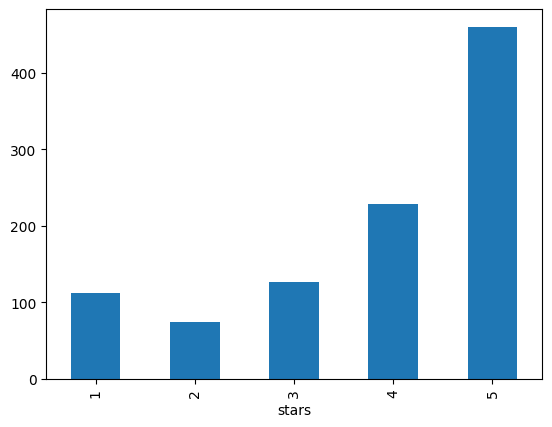

In [10]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [11]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [12]:
review = preview_dfs['review']
for star in range(1,6):
    print(f'Note = {star}:\n=========\n')
    for index in review[review['stars']==star].sample(4, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        print(f'{text}\n\n')

Note = 1:

They have the WORST service advisors! Used to be good before Kelly and her team left. Unfortunately, it's convenient to work if I need oil change before I can make it to another Honda dealer.


It is unfortunate that with such a unique location and such a brand and product offering this specific store offers such lousy service. The wait is endless, no one is available to help and at Christmas time getting a gift wrap is act of God that requires endless wait. I bought gifts and knew that the wait for wrapping would be long SO I even left my items at the store to be gift wrapped at their leisure. They were not even moved from the counter where I bought them when I returned almost two hours later ready for pick up. This was a gift that needed to be given and The staff COMPLETELY "dropped the ball" on my time constraints! 

I love their stuff, but today was my last shopping experience at this location: couldn't get a gift wrapped after being assured that it could be done in a ti

<Axes: xlabel='class'>

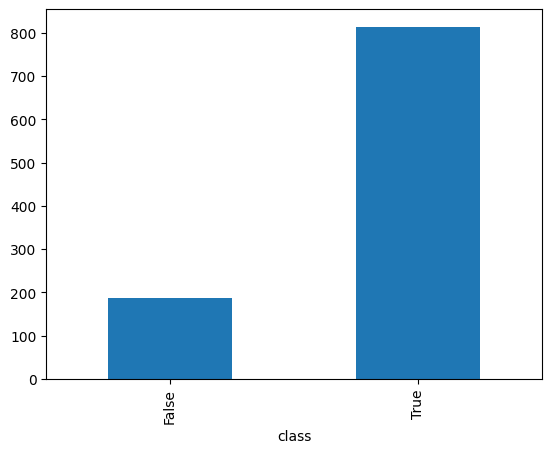

In [13]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [17]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]

# EXTRACTION GOOD/BAD REVIEWS DES RESTAURANTS

## CATEGORIES DE BUSINESS

In [20]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

66781     [Breakfast & Brunch, Restaurants, Food, Juice ...
104986          [Banks & Credit Unions, Financial Services]
145885    [Asian Fusion, Italian, American (New), Salad,...
135125                                      [Food, Grocery]
18620                                   [Shopping, Jewelry]
Name: _cats, dtype: object

In [21]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [22]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurants', 'Pop-Up Restaurants', 'Restaurant Supplies']

In [23]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Food Court',
 'Food Tours',
 'Seafood Markets',
 'Seafood',
 'Food Stands',
 'Food Banks',
 'Food Trucks',
 'Do-It-Yourself Food',
 'Ethnic Food',
 'Live/Raw Food',
 'Imported Food',
 'Specialty Food',
 'Comfort Food',
 'Food Delivery Services',
 'Food',
 'Soul Food',
 'Fast Food']

## REDUCTION DU DATAFRAME REVIEW ET SAUVEGARDE

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation en bad/good reviews (bad <= stars = 3 < good)
- Ne garder que text et séparer en 2 fichiers good/bad news

In [105]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')
restaurants_ids[0:10]

52268 business sont des Restaurants


['MTSW4McQd7CbVtyjqoe9mw',
 'CF33F8-E6oudUQ46HnavjQ',
 'k0hlBqXX-Bt0vf1op7Jr1w',
 'bBDDEgkFA1Otx9Lfe7BZUQ',
 'eEOYSgkmpB90uNA7lDOMRA',
 'il_Ro8jwPlHresjw9EGmBg',
 '0bPLkL0QhhPO5kt1_EXmNQ',
 'MUTTqe8uqyMdBl186RmNeA',
 'ROeacJQwBeh05Rqg7F6TCg',
 'WKMJwqnfZKsAae75RMP6jA']

In [155]:
append = False
good_reviews_file = WORK_DATASET_DIR + 'good_reviews.parquet'
bad_reviews_file = WORK_DATASET_DIR + 'bad_reviews.parquet'

if EXTRACT_PARQUET:
    bad_reviews_counts = 0
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        if bad_reviews_counts < SAMPLING_SIZE:
            restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
            restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')
            restaurant_reviews['class'] = restaurant_reviews['stars'] > 2

            good_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == True])
            bad_reviews = pd.DataFrame(restaurant_reviews[restaurant_reviews['class'] == False])
    
            keep_rows = min(SAMPLING_SIZE - bad_reviews_counts, bad_reviews.shape[0])
            bad_reviews_counts = bad_reviews_counts + keep_rows

            good_reviews.to_parquet(good_reviews_file, engine='fastparquet', append=append)
            bad_reviews.iloc[:keep_rows].to_parquet(bad_reviews_file, engine='fastparquet', append=append)
            append = True
        else:
            break

# TOKENIZATION ET ANALYSE DES BAD REVIEWS 

In [165]:
def tf_idf(reviews_file, drop_words_frequency_under = 4, drop_most_frequent_words = 100, tsne_target = 'stars', verbose = 0):
    from yellowbrick.text import TSNEVisualizer
    # load dataframe and display head
    if verbose > 0: print('Chargement du dataset\n=================\n')
    reviews = pd.read_parquet(reviews_file)

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=drop_most_frequent_words, max_df=drop_most_frequent_words, stop_words="english")
    values = vectorizer.fit_transform(reviews['text'])

    tsne = TSNEVisualizer(decompose_by=min(50, values.shape[1]), decompose='svd')
    tsne.fit(values, reviews[tsne_target])
    tsne.show()
    
    
def find_topics(reviews_file, drop_words_frequency_under = 4, drop_most_frequent_words = 100, n_topics = 10, n_topic_top_words=10, verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)
    
    # load dataframe and display head
    if verbose > 0: print('Chargement du dataset\n=================\n')
    reviews = pd.read_parquet(reviews_file)

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 1: 
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)
    
    # Remove words by frequency
    if verbose > 0:
        print(f'\nSuppression par fréquence\n=================')
        print(f'  - {drop_most_frequent_words} mots les plus fréquents')
        print(f'  - apparaisant moins de {drop_words_frequency_under} fois\n')

    stop_words, nb_words_original = get_stop_words(reviews, drop_words_frequency_under, drop_most_frequent_words, verbose)
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()
    
    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    if verbose > 1:
        # View result sample
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])
    
        # Calc and view text lengths
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    if verbose > 0:        
        # Text length
        total_text_len = reviews['text_len'].sum()
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
    
        print('')

    if verbose > 1:
        # Visualisation Word clound on sample
        cloud_sample_size = min(reviews.shape[0], 1000)
        print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
        sample_text = ' '.join(reviews.sample(cloud_sample_size, random_state=0)['tokens'].str.join(' ').values)
        word_cloud(text=sample_text)
        print('')


    if verbose > 0: print('\nRecherche des topics\n=================\n')
    # Create counter matrix from vocabulary
    topics = lda(reviews, n_topics, n_topic_top_words, verbose)

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)
    
    return topics

In [ ]:
tf_idf(reviews_file=bad_reviews_file, drop_words_frequency_under=2, drop_most_frequent_words=1, tsne_target='stars', verbose=3)

Chargement du dataset

Nombre de textes dupliqués supprimés: 1
Il y a 3999 enregistrements


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,latitude,longitude,stars_business,review_count,is_open,attributes,categories,hours,_cats,class
index,,,,,,,,,,,,,,,,,,,,,
23557,bwzBtlz9KJY1BYsfYAb4kw,n82v9E_jsUIZLBKLM8t4AA,mLUWI7YYwaqTWgmbjOXvKw,1,4,0,1,"Epic fail. 15 minutes after we ordered, we re...",2013-10-06 00:52:32,Tony Luke's,...,39.940025,-74.974246,2.5,93,0,"b'{""BikeParking"":""True"",""BusinessParking"":""{\'...","Restaurants, Food, Burgers, Sandwiches","b'{""Monday"":""11:0-23:0"",""Tuesday"":""11:0-23:0"",...","b'[""Restaurants"",""Food"",""Burgers"",""Sandwiches""]'",False
11173,Cyr7GBIKxT51dVdWjOeifg,bJqLZsSEIzUE5lgYV7Lqjw,EKbb62ui8LgHk3B7OJMyBw,1,1,0,0,"Awful experience, the $10 rolls I got were sup...",2018-08-05 02:50:01,Mizu Sushi Bar,...,38.631424,-90.194493,3.5,235,1,"b'{""RestaurantsReservations"":""True"",""Caters"":""...","Restaurants, Japanese, Sushi Bars","b'{""Monday"":""11:0-22:0"",""Tuesday"":""11:0-22:0"",...","b'[""Restaurants"",""Japanese"",""Sushi Bars""]'",False
22739,wbFN4VLimjelGIq34cYHNw,eFS6uTKsFqwwv2l9gAZHjA,Ql466RUZPLvKo_Cc9kIWzQ,1,0,0,0,"Very sad to say, they are closed. We've been c...",2016-10-02 20:01:43,New Kimono Sushi Bar Japanese & Chinese Restau...,...,40.086889,-75.252112,3.0,28,0,"b'{""RestaurantsGoodForGroups"":""True"",""Alcohol""...","Sushi Bars, Japanese, Chinese, Restaurants","b'{""Monday"":""11:0-22:0"",""Tuesday"":""11:0-22:0"",...","b'[""Sushi Bars"",""Japanese"",""Chinese"",""Restaura...",False
7818,0vi4TMRh9AmemRzAK0WBbQ,mk7YUpkF3CZfkYmD_P3PUA,LliHsFTWhHFlba5HiWHNcg,1,3,0,0,Poor service. Went for lunch. Server acted bo...,2012-04-29 16:04:50,Sushi Ai,...,38.588236,-89.925357,3.0,57,1,"b'{""GoodForKids"":""True"",""Alcohol"":""u\'beer_and...","Restaurants, Sushi Bars, Japanese","b'{""Monday"":""10:30-22:0"",""Tuesday"":""10:30-22:0...","b'[""Restaurants"",""Sushi Bars"",""Japanese""]'",False
28097,TpX0ze4bK1RBsuadYwWrjw,0wrY4WgRAHMRjvI5tgP2Zg,jGewGnIYcf9LFBcR8lMC5g,1,0,0,0,My eyes r still watering .. What the heck the ...,2015-11-20 23:24:04,Picasso Restaurant & Bar,...,39.917912,-75.390854,3.0,34,0,"b'{""RestaurantsReservations"":""True"",""NoiseLeve...","Italian, Spanish, Restaurants, Food",None,"b'[""Italian"",""Spanish"",""Restaurants"",""Food""]'",False


D:\fidle\fidle-env\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'make'] not in stop_words.
  warnings.warn(


In [108]:
vectorizer.get_feature_names_out()

array(['30pm', 'advice', 'age', 'airport', 'ambience', 'appetite',
       'bagel', 'bloody', 'brother', 'class', 'confirm', 'crappy',
       'create', 'cucumber', 'currently', 'discover', 'edge', 'final',
       'fly', 'future', 'gyro', 'hash', 'hello', 'hospitality',
       'impossible', 'interior', 'john', 'mall', 'match', 'monday',
       'movie', 'mozzarella', 'politely', 'prompt', 'ranch', 'redeem',
       'spoil', 'syrup', 'traditional', 'tray', 'trust', 'unable',
       'unfortunate', 'unique', 'weak'], dtype=object)

Chargement du dataset

Nombre de textes dupliqués supprimés: 1
Il y a 3999 enregistrements


,stars,text
index,,
23557,1,"Epic fail. 15 minutes after we ordered, we received the smallest 13 dollar cheesesteak I could even imagine. 13 dollars you say? Oh yes, they charge a dollar for exactly 3 pieces of long hots, and TWO dollars for sharp provalone. And their ""traditional"" size is so cute and little. Like it i..."
11173,1,"Awful experience, the $10 rolls I got were super little. Also, it took forever for our waitress to get to our table for anything. When we got the check, she gave us the same checks and then we asked to fix it charged the wrong card the wrong amount. Never came back for refills also there was bar..."
22739,1,"Very sad to say, they are closed. We've been coming here for probably 20 years. Oh well, time to find our next reliable neighborhood sushi spot."
7818,1,Poor service. Went for lunch. Server acted bored and could not care less. Kitchen brought out my food as she never checked in it. Chicken was good but salad that came with lunch was full of water and premade. Server never refilled my drink and had to be tracked down. Twice. Tables were not ful...
28097,1,My eyes r still watering .. What the heck the smell of ammonia was overpowering at the bar .. Food service and ambience don't matter when u can not breathe ! Really this was bad . Can not imagine what happened to require that disinfecting ...



Preprocess




Tokenize




Suppression par fréquence
  - 20 mots les plus fréquents
  - apparaisant moins de 2 fois

Les 20 mots les plus fréquents:
mot           Nombre d'apparitions
----------  ----------------------
food                          3688
order                         3261
get                           2967
good                          2643
place                         2386
come                          2030
time                          1926
like                          1838
service                       1818
say                           1616
one                           1603
would                         1544
go                            1529
back                          1506
take                          1437
wait                          1409
ask                           1282
table                         1272
make                          1227
restaurant                    1198

4598 mots apparaissent moins de 2 fois:
['tipper' 'kanella' '1970' ... 'gulp' 'chug' 'sakana']




-------------------------------------------------  -----
Nombre de tokens unique initial dans le dataframe  10838
Nombre de stopwords                                 4797
Nombre de tokens unique restant dans le dataframe   6112
-------------------------------------------------  -----

Echantillon du resultat



,stars,tokens
index,,
23557,1,"[epic, fail, minute, receive, small, dollar, cheesesteak, could, even, imagine, dollar, yes, charge, dollar, exactly, piece, long, two, dollar, sharp, traditional, size, cute, little, kid, size, mind, tony, luke, oregon, ave, customer, instead, pat, sandwich, trash, greasy, meat, cook, weird, st..."
11173,1,"[awful, experience, roll, super, little, also, forever, waitress, anything, check, give, check, fix, charge, wrong, card, wrong, amount, never, refill, also, barely, anybody, saturday, night]"
22739,1,"[sad, close, probably, year, well, find, next, reliable, neighborhood, sushi, spot]"
7818,1,"[poor, lunch, server, act, bore, could, care, le, kitchen, bring, never, check, chicken, salad, lunch, full, water, premade, server, never, refill, drink, track, twice, full, empty]"
28097,1,"[eye, still, water, heck, smell, overpower, bar, ambience, matter, breathe, really, bad, imagine, happen, require]"



Analyse des longeurs de text



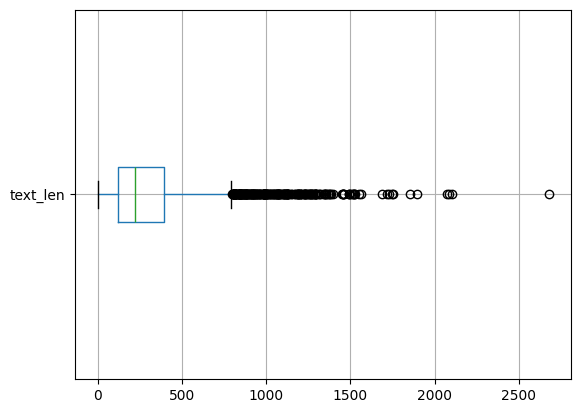

Longeur total du texte dans le dataframe: 1197853


Visualisation du nuage de mot d'un échantillon de 1000 lignes



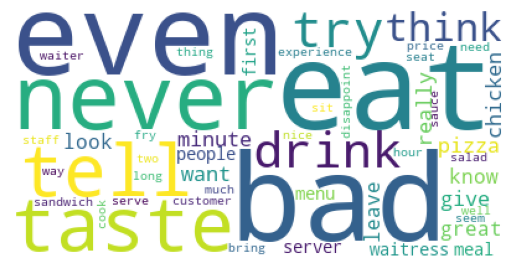



Recherche des topics

  - Creation de la matrice du vocabulaire
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  -------------------------------------------
         0  penn, roam, approx, stat, foodie
         1  stock, reluctant, ignorance, finish, family
         2  everyday, crave, horchata, hunger, thing
         3  vietnam, picture, etiquette, spanish, cup
         4  point, maze, ambiance, traditional, dinner


In [67]:
topics = find_topics(reviews_file=bad_reviews_file,
                     drop_words_frequency_under=2,
                     drop_most_frequent_words=20,
                     n_topics=5, 
                     n_topic_top_words=5,
                     verbose=3)

In [41]:
topics_grid = []
start = time.time()
LINE_UP = '\033[1A'
LINE_CLEAR = '\x1b[2K'

drop_words_frequency_under_range = range(2,11,3)
drop_most_frequent_words_range = range(10, 101, 25)
n_topics_range = range(3,8,2)

total_loops = len(drop_words_frequency_under_range)*len(drop_most_frequent_words_range) * len(n_topics_range)
current_loop = 1
for drop_words_frequency_under in drop_words_frequency_under_range:
    for drop_most_frequent_words in drop_most_frequent_words_range:
        for n_topics in n_topics_range:
            print(f'Recherche {current_loop}/{total_loops}')
            print(f'Temps écoulé {time_from(start)}')
            print(f'Parametres:')
            hyper_params = [['Fréquence minimal d\'un mot', drop_words_frequency_under], ['Top des mots les plus fréquent supprimés', drop_most_frequent_words], ['Nombre de topics', n_topics]]
            print(tabulate(hyper_params,))
            topics = find_topics(reviews_file=bad_reviews_file,
                                              drop_words_frequency_under=drop_words_frequency_under,
                                              drop_most_frequent_words=drop_most_frequent_words,
                                              n_topics=n_topics, 
                                              n_topic_top_words=5,
                                              sample_size = 100,
                                              verbose=0)
            current_loop = current_loop + 1
            clear_output()
            topics_grid.append({'params': 'drop_words_frequency_under\ndrop_most_frequent_words' ,
                                'value': str(drop_words_frequency_under) + '\n' + str(drop_most_frequent_words),
                                'topics': '\n'.join([str(topic[0]) + ' : ' + topic[1] for topic in topics])
                               })

print(f'{total_loops} boucles éxécutées en {time_from(start)}\n\n')
print(tabulate(topics_grid,  headers="keys", tablefmt="grid"))
        

36 boucles éxécutées en 8mn 59s


+----------------------------+---------+-----------------------------------------------------+
| params                     | value   | topics                                              |
+============================+=========+=====================================================+
| drop_words_frequency_under | 2       | 0 : poor, someone, irritate, friend, build          |
| drop_most_frequent_words   | 10      | 1 : sauce, inside, sunday, well, busy               |
|                            |         | 2 : mess, literally, girl, busy, mediocre           |
+----------------------------+---------+-----------------------------------------------------+
| drop_words_frequency_under | 2       | 0 : poor, another, southern, sit, build             |
| drop_most_frequent_words   | 10      | 1 : inside, mediocre, sunday, replacement, probably |
|                            |         | 2 : girl, literally, mess, mediocre, try            |
|               